In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr

intron_annot = pd.read_csv('/project2/yangili1/bjf79/ChromatinSplicingQTLs/data/IntronAnnotationsFromYang.tsv.gz', sep='\t')
intron_annot['junction'] = intron_annot[['chrom', 'start', 'end', 'strand']].astype(str).agg(':'.join, axis=1)
long_table = pd.read_csv(
    '/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/SplicingAnalysis/CombinedJuncTables/YRI.tsv.gz', sep='\t'
)

long_table_ = long_table.loc[long_table.RepNumber == '1.junc'].drop_duplicates()
long_table = long_table_.loc[long_table_.Dataset=='chRNA.Expression.Splicing'].copy()
del long_table_
long_table = long_table.loc[~((long_table.IndID == 'NA18855') & (long_table.Dataset == 'chRNA.Expression.Splicing'))]

expressed_genes = pd.read_csv('../code/ExpressionAnalysis/polyA/ExpressedGeneList.txt', sep ='\t',
                             names = ['chrom', 'start', 'end', 'gene', 'score', 'strand'])

In [2]:
def get_cluster_pct_NMD(clu, df_clu):
    pct_NMD = []
    for df in df_clu.loc[df_clu.cluster.isin(clu)].groupby('cluster'):
        if df[1].isNMD.all():
            pct_NMD.append(1)
        elif not df[1].isNMD.any():
            pct_NMD.append(0)
        elif df[1][chRNA_samples].sum().sum() > 0:
            NMD_counts = df[1].loc[df[1].isNMD][chRNA_samples].sum().sum()
            total_counts = df[1][chRNA_samples].sum().sum()
            pct_NMD.append(NMD_counts/total_counts)
    return pct_NMD

def plot_cumulative(x, steps = 100):
    x = np.array(x)
    X = np.linspace(np.min(x), np.max(x), steps)
    y = [np.mean(x<=z) for z in X]
    return X, y


In [3]:
def get_junction_counts(phenotype='chRNA.Expression.Splicing', subset_samples=[], remove_sample=None):
    
    template = '../code/SplicingAnalysis/leafcutter/clustering/autosomes/leafcutter_perind.counts.gz.{Phenotype}.gz'
    counts = pd.read_csv(template.format(Phenotype=phenotype), sep=' ')
    
    if len(subset_samples) > 0:
        counts = counts[['chrom'] + list(subset_samples)]
        counts.columns = ['cluster_id'] + list(subset_samples)
        
    if remove_sample:
        counts = counts.drop(remove_sample, axis=1)

    
    
    samples = list(counts.columns[1:])
    counts.columns = ['cluster_id'] + samples

    counts[['chrom', 'start', 'end', 'cluster']] = counts['cluster_id'].str.split(':', 3, expand=True)

    counts['strand'] = [x.split('_')[-1] for x in counts.cluster]
    counts['intron'] = counts.chrom + ':' + counts.start.astype(str)+ ':' + counts.end.astype(str) + ':' + counts.strand

    for sample in samples:
        counts[[sample, sample+'_total']] = counts[sample].str.split('/', 1, expand=True)

    counts = counts[['chrom', 'start', 'end', 'cluster', 'intron', 'strand'] + samples]

    counts['start'] = counts['start'].astype(int)
    counts['end'] = counts['end'].astype(int)
    counts[samples] = counts[samples].astype(int)
    
    return counts, samples
    

clusters, chRNA_samples = get_junction_counts(phenotype='chRNA.Expression.Splicing', remove_sample='NA18855')
clusters['intron_coords'] = clusters.chrom + ':' + clusters.start.astype(str) + '-' + clusters.end.astype(str) + ':' + clusters.strand


In [4]:
def get_series_quantile(series, gene_list=None, quant=4):
    
    if not gene_list is None:
        series = series.loc[gene_list].dropna()
    
    q = 1/quant
    
    seriesQ_list = []
    
    for i in range(quant):
        Qi = series.quantile(q*i)
        Qi2 = series.quantile(q*(i+1))
        if i == 0:
            Qi -= 1
        if i == (quant-1):
            Qi2 += 1
        seriesQi = series.loc[(series >= Qi) & (series < Qi2)].index
        
        seriesQ_list.append(seriesQi)
        
    return seriesQ_list

RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

YRI_samples = RPKM.columns[5:]

# RPKM_median = RPKM[
#     [x for x in pd.Index(cluster_table.IndID.unique()).intersection(RPKM.columns) if x !=  'NA18855']
#                   ].median(axis=1)

In [5]:
clusters = clusters.merge(intron_annot.loc[intron_annot.gene.isin(RPKM.index), ['junction', 'SuperAnnotation']], 
               left_on = 'intron', right_on='junction')
clusters = clusters.assign(intron_length=lambda x: x.end - x.start)

clusters['isNMD'] = np.array(
    clusters.SuperAnnotation.isin(['AnnotatedJunc_UnproductiveCodingGene', 'UnannotatedJunc_UnproductiveCodingGene'])
)

In [6]:
clu_list = []
intron_len = []
for df in clusters.loc[clusters.SuperAnnotation.isin(
    ['AnnotatedJunc_ProductiveCodingGene', 'UnannotatedJunc_ProductiveCodingGene']
)].groupby('cluster'):
    len_top_pc = df[1].iloc[df[1][chRNA_samples].sum(axis=1).argmax()].intron_length
    clu_list.append(df[0])
    intron_len.append(len_top_pc)
    
df_clu = pd.DataFrame()
df_clu['intron_length'] = intron_len
df_clu.index = clu_list

In [7]:
from decimal import Decimal 

def plot_clumulative(y, steps = 100):
    X = np.linspace(np.min(y), np.max(y), 100)
    y = np.array(y)
    Y = [np.mean(y<=x) for x in X]
    
    return X, Y

def annotate_pval(X, Y, ax, xy = (0.05, 0.1), col='black'):
    
    corr_label = 'Spearman r'
    corr = spearmanr(X, Y)

    str_cor = "{:.2f}".format(corr[0])#str(round(corr[0], 2))
    str_pval = print_pval(corr[1])

    legend = corr_label + ' = ' + str_cor + '\n' + 'pval = ' + str_pval
    ax.annotate(legend, xy=xy, xycoords='axes fraction', c=col)
    
def print_pval(pval):
    if pval > 0.01:
        str_pval = str(round(pval, 2))
    else:
        str_pval = '%.2E' % Decimal(pval)
    return str_pval


def get_cluster_pct_NMD_clu(clu, df_clu):
    pct_NMD = []
    clu_list = []
    for df in tqdm(df_clu.loc[df_clu.cluster.isin(clu)].groupby('cluster')):
        if df[1].isNMD.all():
            pct_NMD.append(1)
            clu_list.append(df[0])
        elif not df[1].isNMD.any():
            pct_NMD.append(0)
            clu_list.append(df[0])
        elif df[1][chRNA_samples].sum().sum() > 0:
            NMD_counts = df[1].loc[df[1].isNMD][chRNA_samples].sum().sum()
            total_counts = df[1][chRNA_samples].sum().sum()
            pct_NMD.append(NMD_counts/total_counts)
            clu_list.append(df[0])
    return pct_NMD, clu_list


In [8]:
pct_NMD_all, clu_list = get_cluster_pct_NMD_clu(df_clu.index, clusters)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31844/31844 [01:23<00:00, 381.87it/s]


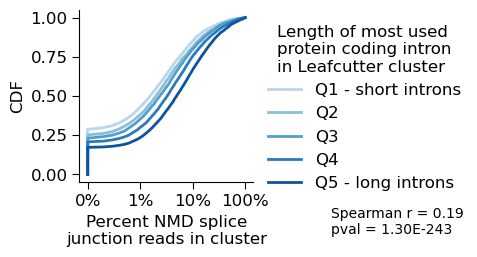

In [9]:
plt.rcParams['legend.title_fontsize'] = 12

clu_10 = get_series_quantile(df_clu.intron_length, quant=5)

colores = sns.color_palette("Blues", 6)

fig, ax = plt.subplots(figsize=(2.24, 2.24))

for i in range(len(clu_10)):
    pct_NMD = get_cluster_pct_NMD(clu_10[i], clusters)
    X, y =  plot_cumulative(pct_NMD, steps=1000)
    if i == 0:
        label = 'Q1 - short introns' 
    elif i == 4:
        label = 'Q5 - long introns'
    else:
        label = 'Q' + str(i+1)
    ax.plot([-3] + list(np.log10(np.array(X)[1:])), [0]+list(y[1:]), c=colores[i+1], linewidth = 2, label=label)

ax.set_xlabel('Percent NMD splice\njunction reads in cluster', size=12)#"Max. prot. coding intron length", size=12)
ax.legend(frameon=False, title='Length of most used\nprotein coding intron\nin Leafcutter cluster', 
          bbox_to_anchor=(1, 1), fontsize=12)
ax.set_ylabel('CDF', size=12)
ax.set_xticks([-3, -2, -1, 0])
ax.set_xticklabels(['0%', '1%', '10%', '100%'])

ax.tick_params(length=5, labelsize=12)


annotate_pval(np.array(df_clu.loc[clu_list].intron_length), np.array(pct_NMD_all), ax, xy = (1.45, -0.3), col='black')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlim([-3, 53])

figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_length_vs_NMD.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_length_vs_NMD.png', dpi=300, bbox_inches='tight',)

In [10]:
def get_series_range(series, range_list):

        
    seriesQ_list = []
    
    seriesQ1 = series.loc[(series <= range_list[0])].index
    seriesQ_list.append(seriesQ1)
    
    seriesQn = series.loc[(series > range_list[-1])].index
    
    
    for i in range(len(range_list)-1):
        Qi = range_list[i]
        Qi2 = range_list[i+1]
        
        seriesQi = series.loc[(series > Qi) & (series <= Qi2)].index
        
        seriesQ_list.append(seriesQi)
        
    seriesQ_list.append(seriesQn)
        
    return seriesQ_list

In [11]:
clu_10 = get_series_range(df_clu.intron_length, [1000, 5000, 20000, 50000])


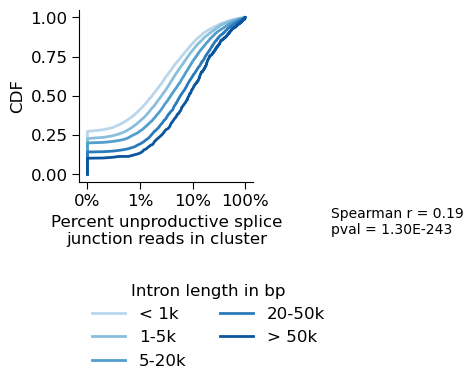

In [44]:
plt.rcParams['legend.title_fontsize'] = 12

# clu_10 = get_series_quantile(df_clu.intron_length, quant=5)

colores = sns.color_palette("Blues", 6)

fig, ax = plt.subplots(figsize=(2.24, 2.24))

label_list = ['< 1k', '1-5k', '5-20k', '20-50k', '> 50k']

for i in range(len(clu_10)):
    pct_NMD = get_cluster_pct_NMD(clu_10[i], clusters)
    X, y =  plot_cumulative(pct_NMD, steps=1000)
    label = label_list[i]
    ax.plot([-3] + list(np.log10(np.array(X)[1:])), [0]+list(y[1:]), c=colores[i+1], linewidth = 2, label=label)

ax.set_xlabel('Percent unproductive splice\njunction reads in cluster', size=12)#"Max. prot. coding intron length", size=12)
ax.legend(frameon=False, title='Intron length in bp', 
          bbox_to_anchor=(1.5, -0.5), fontsize=12, ncols=2)
ax.set_ylabel('CDF', size=12)
ax.set_xticks([-3, -2, -1, 0])
ax.set_xticklabels(['0%', '1%', '10%', '100%'])

ax.tick_params(length=5, labelsize=12)


annotate_pval(np.array(df_clu.loc[clu_list].intron_length), np.array(pct_NMD_all), ax, xy = (1.45, -0.3), col='black')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlim([-3, 53])

# figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_length_vs_NMD.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_length_vs_NMD.png', dpi=300, bbox_inches='tight',)

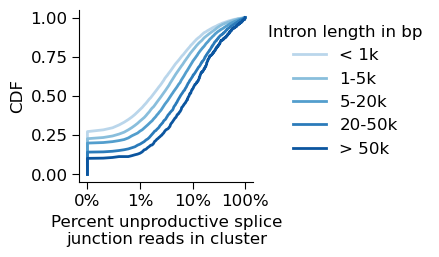

In [13]:
plt.rcParams['legend.title_fontsize'] = 12

# clu_10 = get_series_quantile(df_clu.intron_length, quant=5)

colores = sns.color_palette("Blues", 6)

fig, ax = plt.subplots(figsize=(2.24, 2.24))

label_list = ['< 1k', '1-5k', '5-20k', '20-50k', '> 50k']

for i in range(len(clu_10)):
    pct_NMD = get_cluster_pct_NMD(clu_10[i], clusters)
    X, y =  plot_cumulative(pct_NMD, steps=1000)
    label = label_list[i]
    ax.plot([-3] + list(np.log10(np.array(X)[1:])), [0]+list(y[1:]), c=colores[i+1], linewidth = 2, label=label)

ax.set_xlabel('Percent unproductive splice\njunction reads in cluster', size=12)#"Max. prot. coding intron length", size=12)
ax.legend(frameon=False, title='Intron length in bp', 
          bbox_to_anchor=(1, 1), fontsize=12)
ax.set_ylabel('CDF', size=12)
ax.set_xticks([-3, -2, -1, 0])
ax.set_xticklabels(['0%', '1%', '10%', '100%'])

ax.tick_params(length=5, labelsize=12)


# annotate_pval(np.array(df_clu.loc[clu_list].intron_length), np.array(pct_NMD_all), ax, xy = (1.45, -0.3), col='black')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlim([-3, 53])

# figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

# plt.savefig(figdir + 'Supp_length_vs_NMD.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig(figdir + 'Supp_length_vs_NMD.png', dpi=300, bbox_inches='tight',)

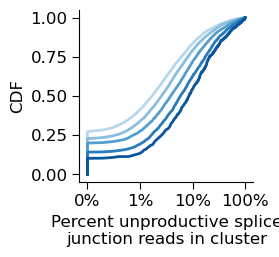

In [14]:
plt.rcParams['legend.title_fontsize'] = 12

# clu_10 = get_series_quantile(df_clu.intron_length, quant=5)

colores = sns.color_palette("Blues", 6)

fig, ax = plt.subplots(figsize=(2.24, 2.24))

label_list = ['< 1k', '1-5k', '5-20k', '20-50k', '> 50k']

for i in range(len(clu_10)):
    pct_NMD = get_cluster_pct_NMD(clu_10[i], clusters)
    X, y =  plot_cumulative(pct_NMD, steps=1000)
    label = label_list[i]
    ax.plot([-3] + list(np.log10(np.array(X)[1:])), [0]+list(y[1:]), c=colores[i+1], linewidth = 2, label=label)

ax.set_xlabel('Percent unproductive splice\njunction reads in cluster', size=12)#"Max. prot. coding intron length", size=12)
# ax.legend(frameon=False, title='Intron length in bp', 
#           bbox_to_anchor=(1, 1), fontsize=12, ncols=2)
ax.set_ylabel('CDF', size=12)
ax.set_xticks([-3, -2, -1, 0])
ax.set_xticklabels(['0%', '1%', '10%', '100%'])

ax.tick_params(length=5, labelsize=12)


# annotate_pval(np.array(df_clu.loc[clu_list].intron_length), np.array(pct_NMD_all), ax, xy = (1.45, -0.3), col='black')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlim([-3, 53])

# figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

# plt.savefig(figdir + 'Supp_length_vs_NMD.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig(figdir + 'Supp_length_vs_NMD.png', dpi=300, bbox_inches='tight',)

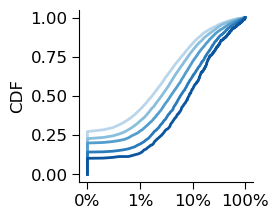

In [15]:
plt.rcParams['legend.title_fontsize'] = 12

# clu_10 = get_series_quantile(df_clu.intron_length, quant=5)

colores = sns.color_palette("Blues", 6)

fig, ax = plt.subplots(figsize=(2.24, 2.24))

label_list = ['< 1k', '1-5k', '5-20k', '20-50k', '> 50k']

for i in range(len(clu_10)):
    pct_NMD = get_cluster_pct_NMD(clu_10[i], clusters)
    X, y =  plot_cumulative(pct_NMD, steps=1000)
    label = label_list[i]
    ax.plot([-3] + list(np.log10(np.array(X)[1:])), [0]+list(y[1:]), c=colores[i+1], linewidth = 2, label=label)

# ax.set_xlabel('Percent unproductive splice\njunction reads in cluster', size=12)#"Max. prot. coding intron length", size=12)
# ax.legend(frameon=False, title='Intron length in bp', 
#           bbox_to_anchor=(1, 1), fontsize=12, ncols=2)
ax.set_ylabel('CDF', size=12)
ax.set_xticks([-3, -2, -1, 0])
ax.set_xticklabels(['0%', '1%', '10%', '100%'])

ax.tick_params(length=5, labelsize=12)


# annotate_pval(np.array(df_clu.loc[clu_list].intron_length), np.array(pct_NMD_all), ax, xy = (1.45, -0.3), col='black')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlim([-3, 53])

figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_length_vs_NMD_no_legend.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_length_vs_NMD_no_legend.png', dpi=300, bbox_inches='tight',)

In [16]:
X_list = []
y_list = []
for i in range(len(clu_10)):
    pct_NMD = get_cluster_pct_NMD(clu_10[i], clusters)
    X, y =  plot_cumulative(pct_NMD, steps=1000)
    X_list.append(X)
    y_list.append(y)

    

In [17]:
X_list

[array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

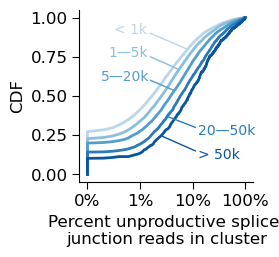

In [27]:
plt.rcParams['legend.title_fontsize'] = 12

# clu_10 = get_series_quantile(df_clu.intron_length, quant=5)

colores = sns.color_palette("Blues", 6)

fig, ax = plt.subplots(figsize=(2.24, 2.24))

label_list = ['< 1k', '1—5k', '5—20k', '20—50k', '> 50k']

for i in range(len(clu_10)):
    X = X_list[i]
    y = y_list[i]
#     X, y =  plot_cumulative(pct_NMD, steps=1000)
    label = label_list[i]
    ax.plot([-3] + list(np.log10(np.array(X)[1:])), [0]+list(y[1:]), c=colores[i+1], linewidth = 2, label=label)

# ax.set_xlabel('Percent unproductive splice\njunction reads in cluster', size=12)#"Max. prot. coding intron length", size=12)
# ax.legend(frameon=False, title='Intron length in bp', 
#           bbox_to_anchor=(1, 1), fontsize=12, ncols=2)
ax.set_ylabel('CDF', size=12)
ax.set_xticks([-3, -2, -1, 0])
ax.set_xticklabels(['0%', '1%', '10%', '100%'])

ax.tick_params(length=5, labelsize=12)


# annotate_pval(np.array(df_clu.loc[clu_list].intron_length), np.array(pct_NMD_all), ax, xy = (1.45, -0.3), col='black')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(-2.5, 0.9, label_list[0], c=colores[1])
ax.plot([-1.8, np.log10(X_list[0][80])], [0.9, y_list[0][80]], linewidth=1, c=colores[1])

ax.text(-2.6, 0.75, label_list[1], c=colores[2])
ax.plot([-1.8, np.log10(X_list[1][55])], [0.75, y_list[1][55]], linewidth=1, c=colores[2])

ax.text(-2.75, 0.6, label_list[2], c=colores[3])
ax.plot([-1.8, np.log10(X_list[2][45])], [0.6, y_list[2][45]], linewidth=1, c=colores[3])


ax.text(-0.9, 0.25, label_list[3], c=colores[4])
ax.plot([-0.95, np.log10(X_list[3][33])], [0.3, y_list[3][33]], linewidth=1, c=colores[4])

ax.text(-0.9, 0.1, label_list[4], c=colores[5])
ax.plot([-0.95, np.log10(X_list[4][25])], [0.15, y_list[4][25]], linewidth=1, c=colores[5])

ax.set_xlabel('Percent unproductive splice \njunction reads in cluster', size=12)#"Max. prot. coding intron length", size=12)


figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_length_vs_NMD_no_legend.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_length_vs_NMD_no_legend.png', dpi=300, bbox_inches='tight',)

In [ ]:
# clu_10 = get_series_quantile(df_clu.intron_length, quant=5)

# colores = sns.color_palette("Blues", 6)

# fig, ax = plt.subplots(figsize=(2.24, 2.24))

# for i in range(len(clu_10)):
#     pct_NMD = get_cluster_pct_NMD(clu_10[i], clusters)
#     X, y =  plot_cumulative(pct_NMD, steps=1000)
#     ax.plot([-3] + list(np.log10(np.array(X)[1:])), [0]+list(y[1:]), c=colores[i+1], linewidth = 2, label='Q'+str(i+1))

# ax.set_xlabel('Pct. NMD', size=12)#"Max. prot. coding intron length", size=12)
# ax.legend(frameon=False, title='prot. coding intron\nlength quantiles', bbox_to_anchor=(1, 1), fontsize=12)
# ax.set_ylabel('Cumulative\ndistribution', size=12)
# ax.set_xticks([-3, -2, -1, 0])
# ax.set_xticklabels(['0%', '1%', '10%', '100%'])
# # ax.set_xlim([-3, 53])

In [ ]:
# clu_10 = get_series_quantile(df_clu.intron_length, quant=10)

# colores = sns.color_palette("Blues", 11)

# fig, ax = plt.subplots(figsize=(2.24, 2.24))

# for i in range(len(clu_10)):
#     pct_NMD = get_cluster_pct_NMD(clu_10[i], clusters)
#     X, y =  plot_cumulative(pct_NMD, steps=1000)
#     ax.plot([-3] + list(np.log10(np.array(X)[1:])), [0]+list(y[1:]), c=colores[i+1], linewidth = 2, label='Q'+str(i+1))

# ax.set_xlabel('Pct. NMD', size=12)#"Max. prot. coding intron length", size=12)
# ax.legend(frameon=False, title='prot. coding intron\nlength quantiles', bbox_to_anchor=(1, 1), fontsize=12)
# ax.set_ylabel('Cumulative\ndistribution', size=12)
# ax.set_xticks([-3, -2, -1, 0])
# ax.set_xticklabels(['0%', '1%', '10%', '100%'])
# # ax.set_xlim([-3, 53])

In [28]:
scores = pd.read_csv('../../media-1.tsv', sep='\t', index_col=0)

In [29]:
long_table.stop += 1

long_table = long_table.merge(intron_annot, left_on=['chrom', 'start', 'stop', 'strand'],
                right_on=['chrom', 'start', 'end', 'strand'])

long_table['gene'] = [x.split('.')[0] for x in long_table.gene]


RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

YRI_samples = RPKM.columns[5:]
RPKM.index = [x.split('.')[0] for x in RPKM.index]

In [30]:
shared_genes = pd.Index(long_table.gene.unique()).intersection(RPKM.index)

In [31]:
long_table_sum = long_table.groupby(['gene', 'symbol', 'junction', 'NewAnnotation', 'SuperAnnotation']
                                   ).Count.sum().reset_index()

In [32]:
NMD = ['UnannotatedJunc_UnproductiveCodingGene', 'AnnotatedJunc_UnproductiveCodingGene']
NMD_sum = long_table_sum.loc[long_table_sum.SuperAnnotation.isin(NMD)].groupby('gene').Count.sum()
total_sum = long_table_sum.groupby('gene').Count.sum()

In [33]:
NMD_pct_gene = NMD_sum.loc[shared_genes.intersection(NMD_sum.index)]/total_sum.loc[shared_genes.intersection(NMD_sum.index)]

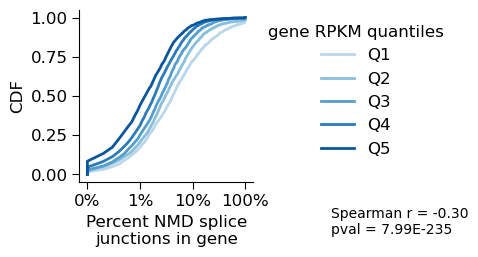

In [43]:
RPKM_q = get_series_quantile(RPKM.loc[shared_genes.intersection(NMD_sum.index), chRNA_samples].median(axis=1), quant=5)

colores = sns.color_palette("Blues", 6)

fig, ax = plt.subplots(figsize=(2.24, 2.24))

X_list2 = []
y_list2 = []

for i in range(len(RPKM_q)):
    pct_NMD = np.array(NMD_pct_gene.loc[RPKM_q[i]])
    X, y =  plot_cumulative(pct_NMD, steps=1000)
    X_list2.append(X)
    y_list2.append(y)
    if i == 0:
        label = 'Q1' 
    elif i == 4:
        label = 'Q5'
    else:
        label = 'Q' + str(i+1)
    ax.plot([-3] + list(np.log10(np.array(X)[1:])), [0]+list(y[1:]), c=colores[i+1], linewidth = 2, label=label)

ax.set_xlabel('Percent NMD splice\njunctions in gene', size=12)#"Max. prot. coding intron length", size=12)
ax.legend(frameon=False, title='gene RPKM quantiles', bbox_to_anchor=(1, 1), fontsize=12)
ax.set_ylabel('CDF', size=12)
ax.set_xticks([-3, -2, -1, 0])
ax.set_xticklabels(['0%', '1%', '10%', '100%'])

ax.tick_params(length=5, labelsize=12)


annotate_pval(RPKM.loc[shared_genes.intersection(NMD_sum.index), chRNA_samples].median(axis=1), 
              NMD_pct_gene.loc[shared_genes.intersection(NMD_sum.index)], 
              ax, xy = (1.45, -0.3), col='black')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlim([-3, 53])

figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_RPKM_vs_NMD.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_RPKM_vs_NMD.png', dpi=300, bbox_inches='tight',)

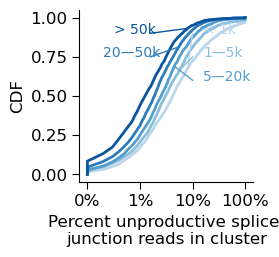

In [40]:
plt.rcParams['legend.title_fontsize'] = 12

# clu_10 = get_series_quantile(df_clu.intron_length, quant=5)

colores = sns.color_palette("Blues", 6)

fig, ax = plt.subplots(figsize=(2.24, 2.24))

label_list = ['< 1k', '1—5k', '5—20k', '20—50k', '> 50k']

for i in range(len(clu_10)):
    X = X_list2[i]
    y = y_list2[i]
#     X, y =  plot_cumulative(pct_NMD, steps=1000)
    label = label_list[i]
    ax.plot([-3] + list(np.log10(np.array(X)[1:])), [0]+list(y[1:]), c=colores[i+1], linewidth = 2, label=label)

# ax.set_xlabel('Percent unproductive splice\njunction reads in cluster', size=12)#"Max. prot. coding intron length", size=12)
# ax.legend(frameon=False, title='Intron length in bp', 
#           bbox_to_anchor=(1, 1), fontsize=12, ncols=2)
ax.set_ylabel('CDF', size=12)
ax.set_xticks([-3, -2, -1, 0])
ax.set_xticklabels(['0%', '1%', '10%', '100%'])

ax.tick_params(length=5, labelsize=12)


# annotate_pval(np.array(df_clu.loc[clu_list].intron_length), np.array(pct_NMD_all), ax, xy = (1.45, -0.3), col='black')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(-0.8, 0.9, label_list[0], c=colores[1])
ax.plot([-1, np.log10(X_list2[0][80])], [0.9, y_list2[0][80]], linewidth=1, c=colores[1])

ax.text(-0.8, 0.75, label_list[1], c=colores[2])
ax.plot([-1, np.log10(X_list2[1][55])], [0.75, y_list2[1][55]], linewidth=1, c=colores[2])

ax.text(-0.8, 0.6, label_list[2], c=colores[3])
ax.plot([-1, np.log10(X_list2[2][45])], [0.6, y_list2[2][45]], linewidth=1, c=colores[3])


ax.text(-2.7, 0.75, label_list[3], c=colores[4])
ax.plot([-1.8, np.log10(X_list2[3][55])], [0.75, y_list2[3][55]], linewidth=1, c=colores[4])

ax.text(-2.5, 0.9, label_list[4], c=colores[5])
ax.plot([-1.8, np.log10(X_list2[4][80])], [0.9, y_list2[4][80]], linewidth=1, c=colores[5])

ax.set_xlabel('Percent unproductive splice \njunction reads in cluster', size=12)#"Max. prot. coding intron length", size=12)


figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_RPKM_vs_NMD_no_legend.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_RPKM_vs_NMD_no_legend.png', dpi=300, bbox_inches='tight',)

In [17]:
genes = pd.read_csv('../../genes.txt', sep='\t', names=['genes'], index_col=0)
genes.index = [x.split('.')[0] for x in genes.index]

srsf = ['SRSF'+str(x) for x in range(13)]
srsf_ensembl = genes.loc[genes.genes.isin(srsf)].index.intersection(RPKM.index)

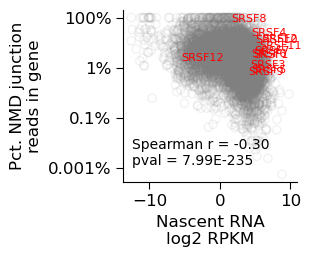

In [18]:
fig, ax = plt.subplots(figsize=(2.24, 2.24))

ax.scatter(RPKM.loc[shared_genes.intersection(NMD_sum.index), chRNA_samples].median(axis=1), 
            np.log10(NMD_pct_gene.loc[shared_genes.intersection(NMD_sum.index)]), 
          facecolor='none', edgecolor='grey', alpha=0.1)

# ax.scatter(RPKM.loc[srsf_ensembl.intersection(shared_genes.intersection(NMD_sum.index)), chRNA_samples].median(axis=1), 
#             np.log2(NMD_pct_gene.loc[srsf_ensembl.intersection(shared_genes.intersection(NMD_sum.index))]), 
#           facecolor='none', edgecolor='red', alpha=0.9)

for sr_gene in srsf_ensembl.intersection(shared_genes.intersection(NMD_sum.index)):
    ax.annotate(genes.loc[sr_gene].genes, (RPKM.loc[sr_gene, chRNA_samples].median()-1, 
               np.log10(NMD_pct_gene.loc[sr_gene])-0.15), c='red', fontsize=8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

annotate_pval(RPKM.loc[shared_genes.intersection(NMD_sum.index), chRNA_samples].median(axis=1), 
            np.log2(NMD_pct_gene.loc[shared_genes.intersection(NMD_sum.index)]), ax, xy = (0.05, 0.1), col='black')

ax.set_yticks([-6, -4, -2, 0])
ax.set_yticklabels(['0.001%', '0.1%', '1%', '100%'])

ax.set_xlabel('Nascent RNA\nlog2 RPKM', size=12)
ax.set_ylabel('Pct. NMD junction\nreads in gene', size=12)

ax.tick_params(length=5, labelsize=12)

figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_RPKM_vs_NMD_scatter.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_RPKM_vs_NMD_scatter.png', dpi=300, bbox_inches='tight',)

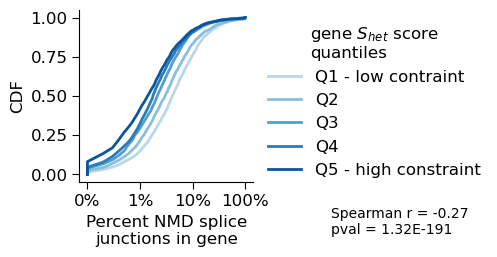

In [26]:
scores = pd.read_csv('../../media-1.tsv', sep='\t', index_col=0)

s_het_q = get_series_quantile(scores.loc[scores.index.intersection(NMD_pct_gene.index)].post_mean, quant=5)

colores = sns.color_palette("Blues", 6)

fig, ax = plt.subplots(figsize=(2.24, 2.24))

for i in range(len(s_het_q)):
    pct_NMD = np.array(NMD_pct_gene.loc[s_het_q[i]])
    X, y =  plot_cumulative(pct_NMD, steps=1000)
    if i == 0:
        label = 'Q1 - low contraint' 
    elif i == 4:
        label = 'Q5 - high constraint'
    else:
        label = 'Q' + str(i+1)
    ax.plot([-3] + list(np.log10(np.array(X)[1:])), [0]+list(y[1:]), c=colores[i+1], linewidth = 2, label=label)

ax.set_xlabel('Percent NMD splice\njunctions in gene', size=12)#"Max. prot. coding intron length", size=12)
ax.set_ylabel('CDF', size=12)
ax.set_xticks([-3, -2, -1, 0])
ax.set_xticklabels(['0%', '1%', '10%', '100%'])

ax.legend(frameon=False, title='gene $S_{het}$ score\nquantiles', bbox_to_anchor=(1, 1), fontsize=12)

annotate_pval(np.log10(scores.loc[scores.index.intersection(NMD_pct_gene.index)].post_mean),
            np.log10(NMD_pct_gene.loc[scores.index.intersection(NMD_pct_gene.index)]), ax, xy = (1.45, -0.3), col='black')

ax.tick_params(length=5, labelsize=12)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlim([-3, 53])

figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_S_het_score_vs_NMD.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_S_het_score_vs_NMD.png', dpi=300, bbox_inches='tight',)